#### WARNING

random_state 미지정으로 재실행시 결과값이 달라질 수 있음을 참고해주세요.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statsmodels.api import qqplot,add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import export_graphviz
import graphviz
from scipy import stats
from scipy.stats import chi2_contingency


In [3]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from collections import Counter
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor

# 데이터 구성

### 데이터 로드 및 설명

In [ ]:
df = pd.read_csv('Car_final.csv')
df.head()

,Brand,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
0,Maruti,Mumbai,2682.68,2010,72000,ETC,Manual,First,26.60,998,58.16,5
1,Hyundai,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67,1582,126.20,5
2,Honda,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.20,1199,88.70,5
3,Maruti,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77,1248,88.76,7
4,Audi,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.20,1968,140.80,5


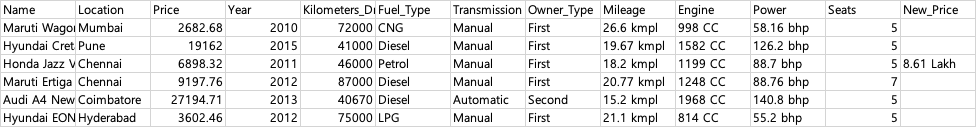

- Brand : 기존 Name 컬럼에서 상세한 모델명을 제외한 순수 브랜드 이름
- Fuel Type : CNG, LPG, electric 같이 개수가 작은 수준값들을 ETC로 묶음
- Mileage : 결측치를 엑셀에서 브랜드별 평균값으로 대치
- Engine, Power, Seats : 구글에서 차량 정보를 찾아 대체
- New_Price : 결측값이 다수이므로 제외

### 데이터 전처리

#### a. 소유형태
- first, second, third 등으로 되어있던 값을 1,2,3,4로 교체
- 직접소유 : 1, 중고차량 : 그 외

In [5]:
for i, j in zip( list(df["Owner_Type"].unique()), [1,2,4,3]) : df["Owner_Type"] = df["Owner_Type"].replace({i:j})

#### b. price 결측값 제거
- 1000여개의 결측값이 존재하므로 제거

In [6]:
drop_ind = df[df['Price'].isna()].index
df.drop(drop_ind, axis = 0, inplace = True)
df.reset_index(drop = True, inplace = True)

#### c. 좌석수
- 수치형에서 범주형으로 변경

In [7]:
df['Seats'] = df['Seats'].astype('object')

In [8]:
df_cat = df.select_dtypes(include = 'object')

In [9]:
df_num = df.select_dtypes(exclude = 'object')

#### d. year -> 연식으로 변경
- 데이터 집계가 종료된 시점인 2021년을 기준으로 연식 계산
- 예) 기존 Year 데이터 2017년 -> 2021 - 2017 = 4

In [10]:
df['Used_Year'] = 2021 - df['Year']

In [11]:
df.drop(columns = 'Year', inplace = True)

#### e. 판매 지역 -> 북부, 남부, 서부, 동부
- 판매 지역들의 위치를 파악 후 중부, 서부, 북부, 동부로 재분류

In [12]:
def replace_location(x):
    if x == 'Ahmedabad':
        x = 'W'
    elif x == 'Bangalore':
        x = 'S'
    elif x == 'Chennai':
        x = 'S'
    elif x == 'Coimbatore':
        x = 'S'
    elif x == 'Delhi':
        x = 'N'
    elif x == 'Hyderabad':
        x = 'S'
    elif x == 'Jaipur':
        x = 'N'
    elif x == 'Kochi':
        x = 'S'
    elif x == 'Kolkata':
        x = 'E'
    elif x == 'Mumbai':
        x = 'W'
    else:
        x = 'W'
    return x

df['Location_2'] = df['Location'].apply(lambda x : replace_location(x))

In [13]:
df.drop(columns = 'Location',inplace = True)

<AxesSubplot:xlabel='Location_2', ylabel='Price'>

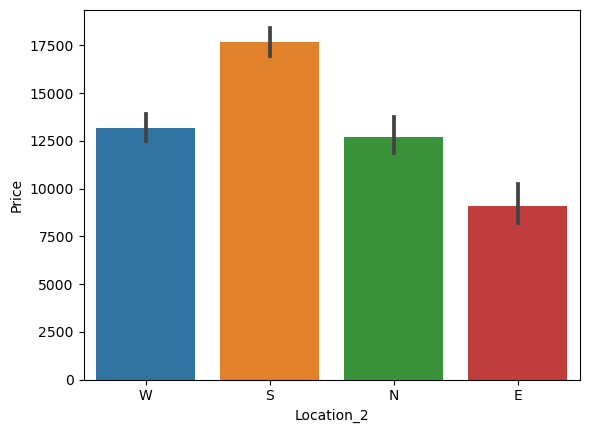

In [14]:
# 시각화
sns.barplot(x = 'Location_2', y = 'Price', data = df)

#### f. 자동차 브랜드 : 고가/중가/저가 브랜드로 재분류
- 자동차 브랜드별 평균 가격을 계산한 뒤 상위 33%, 66%, 그 외를 상, 중, 하로 재분류

<AxesSubplot:xlabel='Brand', ylabel='Price'>

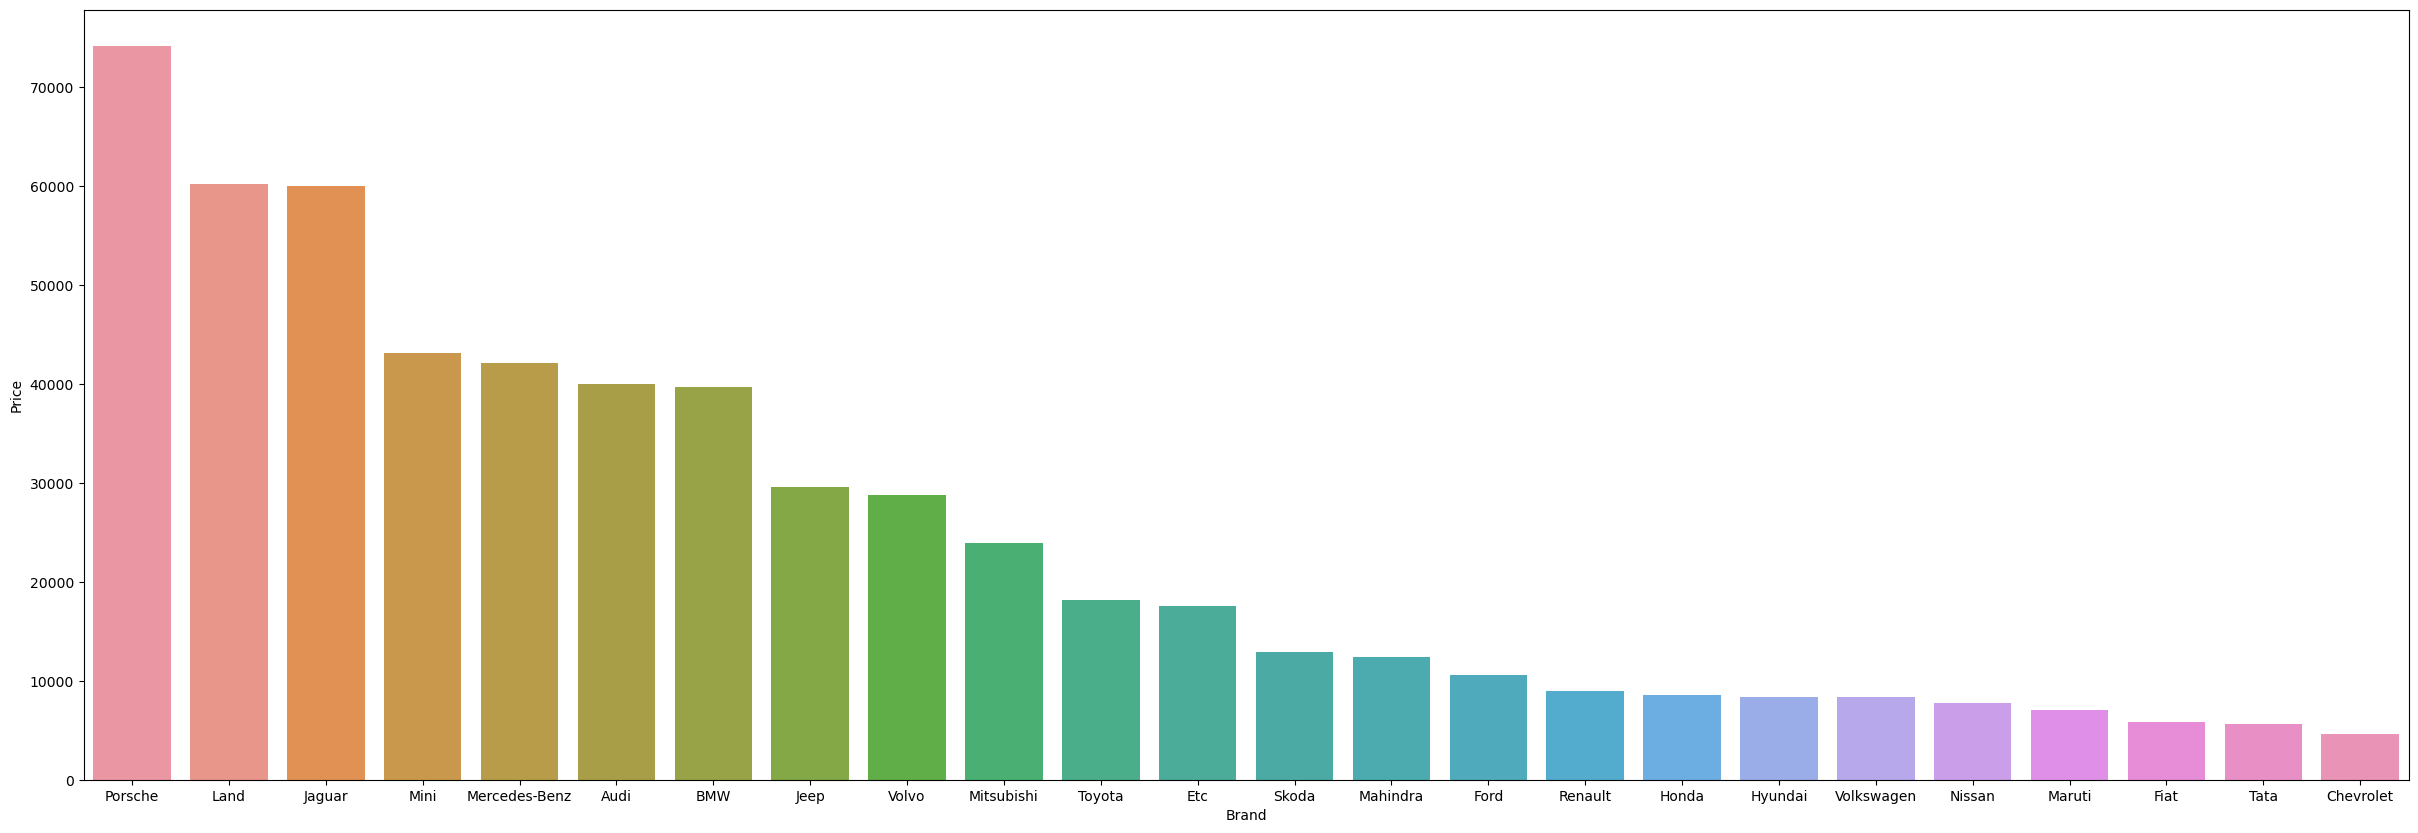

In [16]:
# 브랜드별 가격, 연비, 엔진, 출력
df_brand_group = df.groupby('Brand',as_index = False)[['Price']].mean()
df_brand_group.sort_values(by = 'Price', ascending = False, inplace = True)
fig = plt.figure(figsize = (30,10))
sns.barplot(data = df_brand_group, x = 'Brand', y = 'Price')
# cols = ['Price','Mileage','Engine','Power']
# fig, axes = plt.subplots(nrows = 4, ncols = 1, figsize = (40,40))

# for i,col in enumerate(cols):
#     sns.barplot(data = df_brand_group, x = 'Brand', y = col, ax = axes[i])
#     plt.tight_layout()

In [18]:
upper_33 = np.quantile(list(df.groupby('Brand')['Price'].mean()),0.66)
lower_33 = np.quantile(list(df.groupby('Brand')['Price'].mean()),0.33)

def label_price_category(group, high_price = upper_33, low_price = lower_33):
    group_mean = group.mean()
    top_33 = group.quantile(0.66)
#     print(top_33)
    if group_mean > high_price:
        return 'High'
    elif group_mean > low_price:
        return 'Middle'
    else:
        return 'Low'


In [19]:
df['BRAND_TIER'] = df.groupby('Brand')['Price'].transform(label_price_category)
df.head()
df.drop(columns = 'Brand', inplace = True)

### 데이터 확인

#### a. 상관관계 히트맵

<AxesSubplot:>

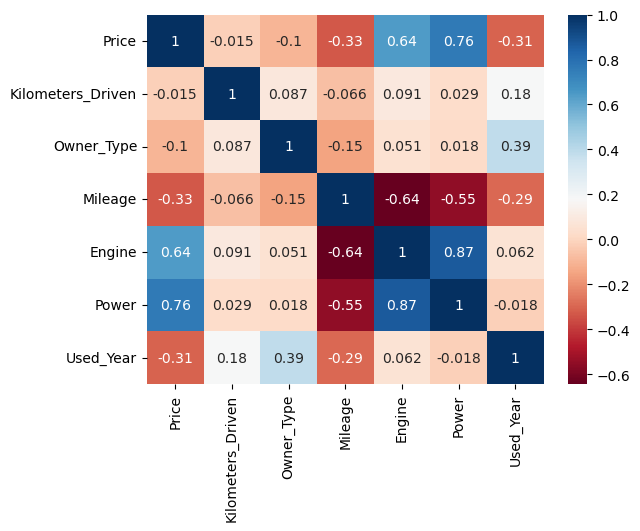

In [21]:
df_corr = df.corr()
sns.heatmap(df_corr,annot=True, cmap = 'RdBu')

- 가격에 영향 많이 주는 요인들 상관관계로 확인
- Year(차량 출시년도), Power, Engine은 가격을 결정하는 데 중요한 요소일 수도 있다.
- 다만, Power와 Engine은 서로 영향을 주고 받을 수 있음

#### b. 데이터 분포 확인 - 히스토그램 / pairplot

array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'Kilometers_Driven'}>,
        <AxesSubplot:title={'center':'Owner_Type'}>],
       [<AxesSubplot:title={'center':'Mileage'}>,
        <AxesSubplot:title={'center':'Engine'}>,
        <AxesSubplot:title={'center':'Power'}>],
       [<AxesSubplot:title={'center':'Used_Year'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

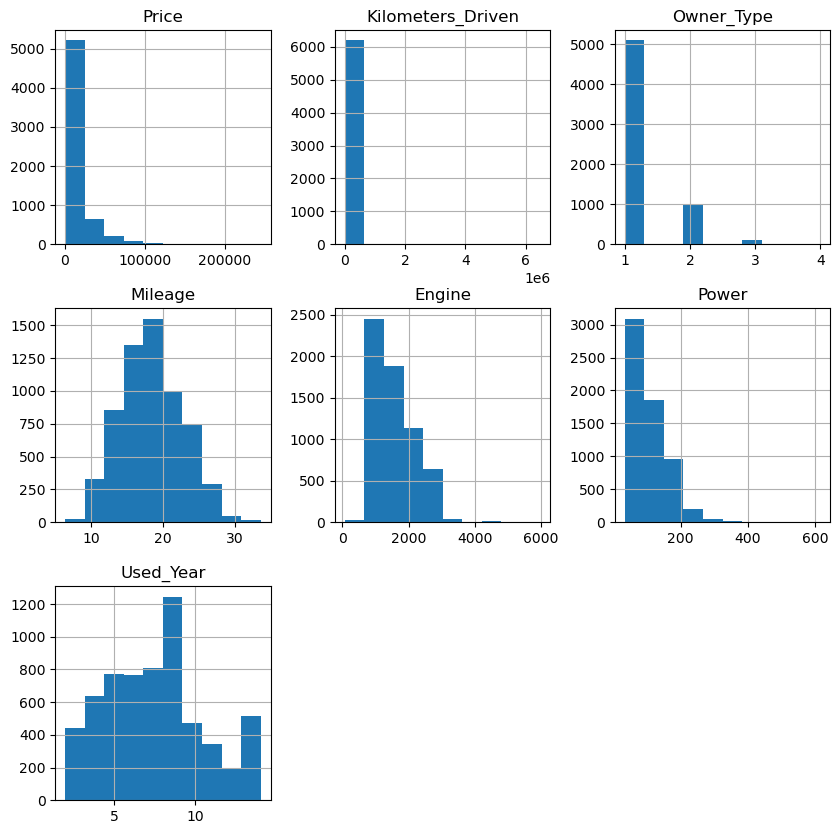

In [22]:
df.hist(figsize = (10,10))

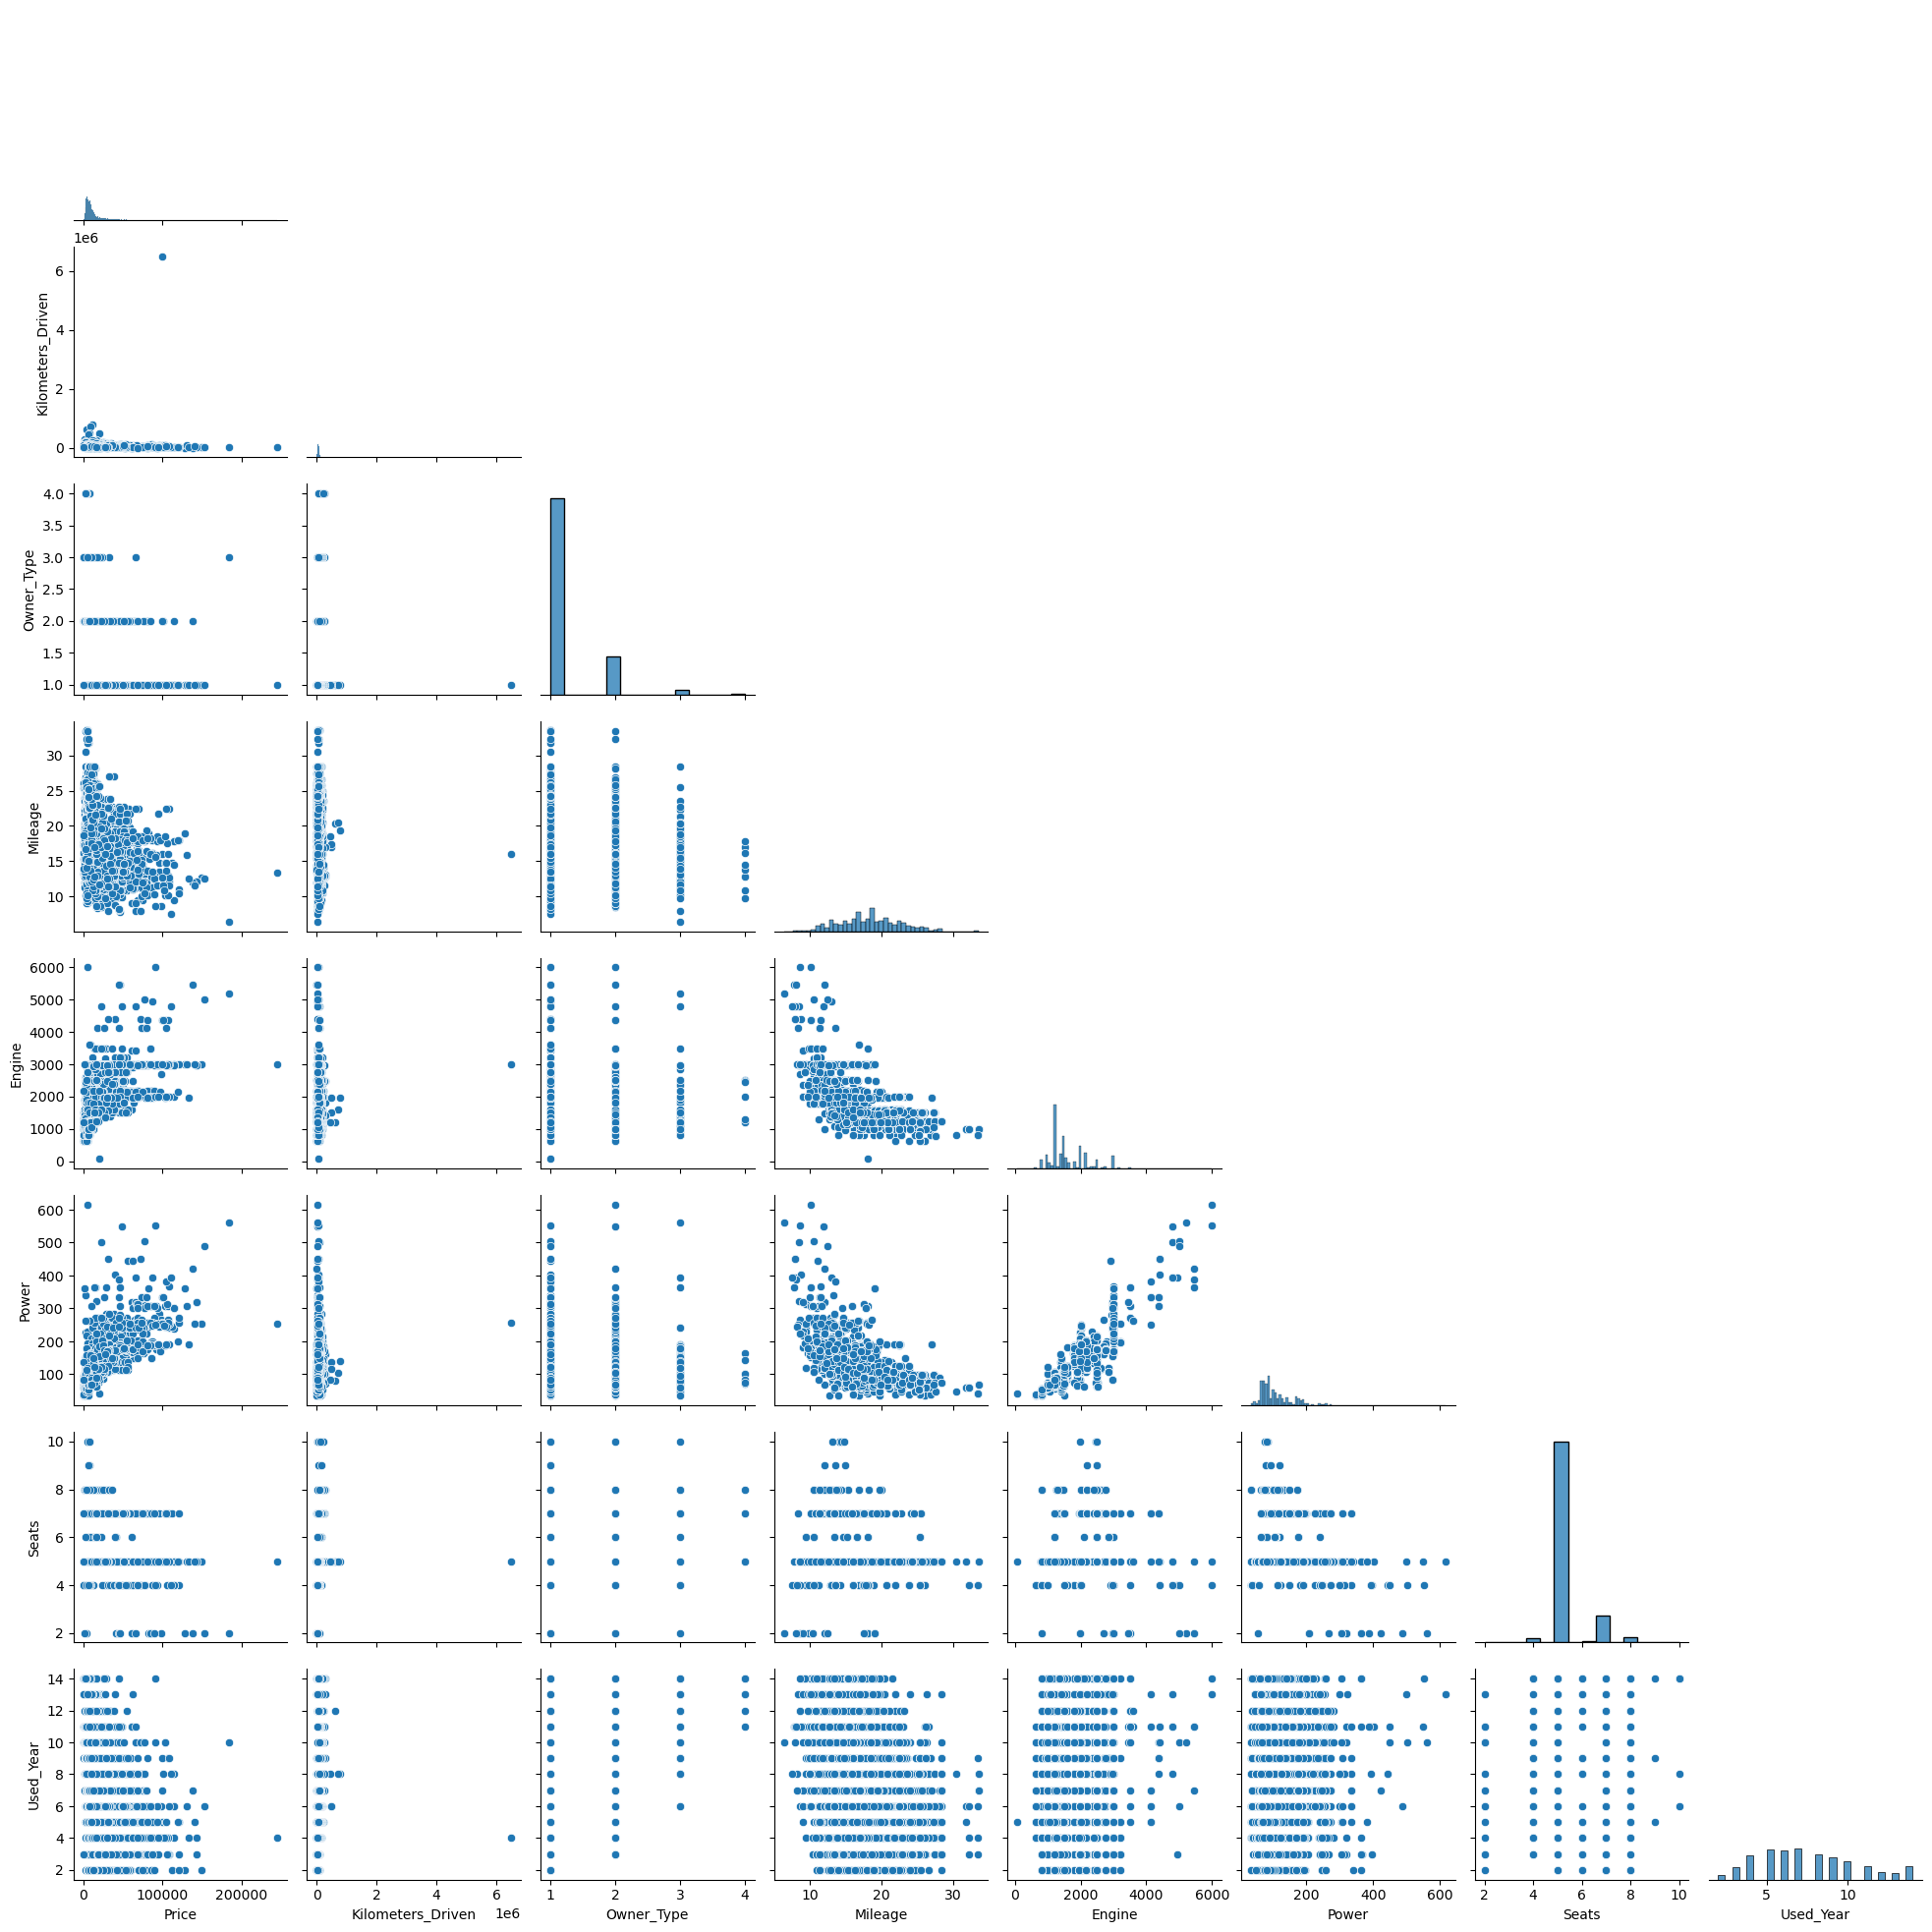

In [23]:
sns.pairplot(corner = True, data = df)

#### c. 박스플롯으로 이상치 및 분포 확인

<AxesSubplot:ylabel='Used_Year'>

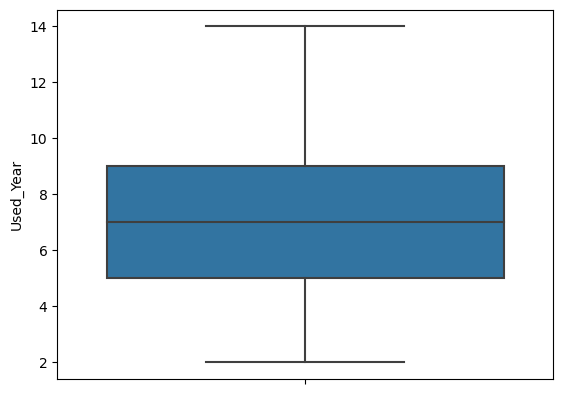

In [24]:
sns.boxplot(y= 'Used_Year', data = df)

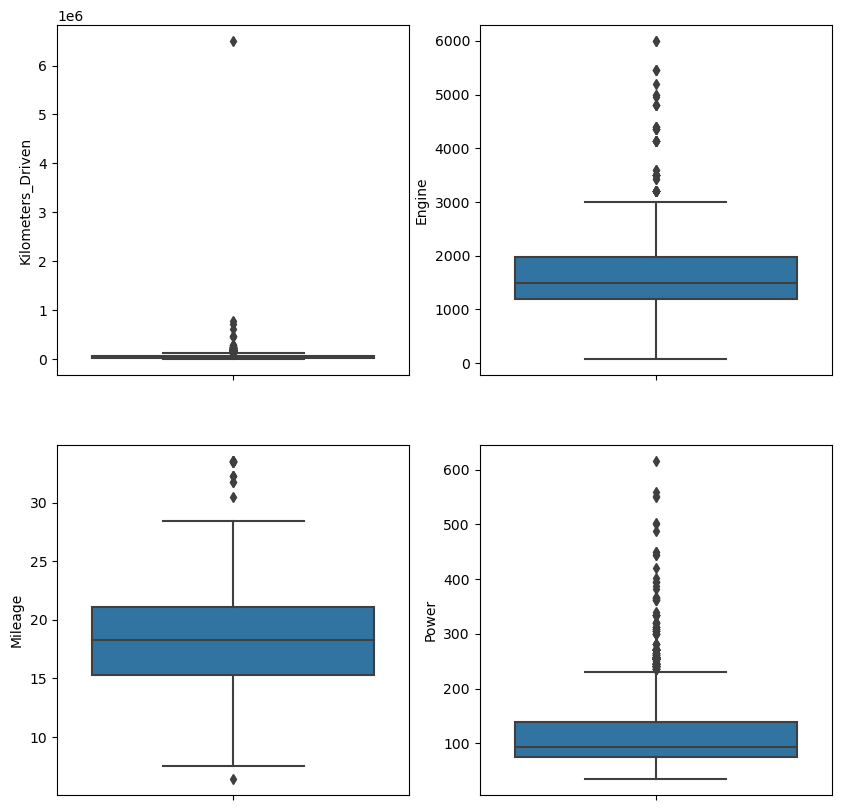

In [25]:
fig,axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))
cols = ['Kilometers_Driven','Mileage','Engine','Power']


for i,col in enumerate(cols):
    sns.boxplot(y = col, data = df, ax = axes[i%2][i//2])
    

- 여러 컬럼에서 이상치가 확인됨

#### d. 이상치 제거 : esd
- 평균 기준으로 +- 3표준편차 밖에 있는 데이터를 이상치로 판단.

In [27]:
#%% 이상치 제거 한 번 해볼까
def esd(x, i) :
    upper = x[i].mean() + 3 * x[i].std()
    under = x[i].mean() - 3 * x[i].std()
    x = x[ x[i] <= upper ]
    x = x[ x[i] >= under ]
    x.reset_index(drop = True, inplace = True)
    return x
for i in df.drop(['Owner_Type','Seats',"Price"], axis = 1).select_dtypes(exclude = "object").columns :
    df = esd(df, i)

In [28]:
df2 = df

In [29]:
# cols = ['Kilometers_Driven','Mileage','Engine','Power']
# def find_outliers(df = None, cols = None):
#     for col in cols:
#         q1 = np.quantile(df[col],0.25)
#         q3 = np.quantile(df[col],0.75)
#         iqr = q3 - q1
#         print(df.shape[0])
#         lower_outlier_index = df[df[col] < q1 - 1.5 * iqr].index
#         upper_outlier_index = df[df[col] > q3 + 1.5 * iqr].index
        
#         df.drop(index = lower_outlier_index, inplace = True)
#         df.drop(index = upper_outlier_index, inplace = True)
#         df.reset_index(drop = True, inplace = True)

#         print(f'{col} : {len(lower_outlier_index)}')
#         print(f'{col} : {len(upper_outlier_index)}')
        
#         print(df.shape[0])
        
#     return df
        
        


In [30]:
# df = find_outliers(df,cols)

<AxesSubplot:xlabel='Kilometers_Driven', ylabel='Count'>

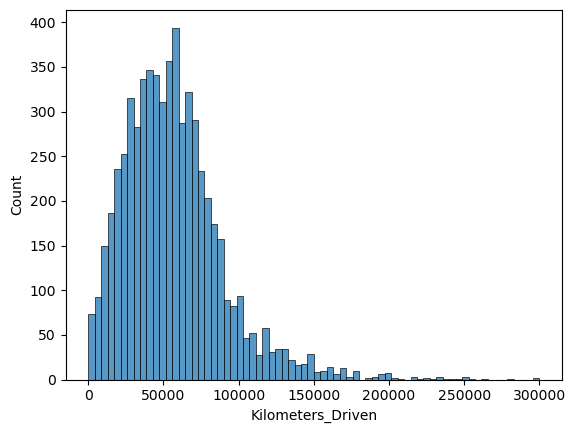

In [31]:
sns.histplot(x = 'Kilometers_Driven', data = df)

array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'Kilometers_Driven'}>,
        <AxesSubplot:title={'center':'Owner_Type'}>],
       [<AxesSubplot:title={'center':'Mileage'}>,
        <AxesSubplot:title={'center':'Engine'}>,
        <AxesSubplot:title={'center':'Power'}>],
       [<AxesSubplot:title={'center':'Used_Year'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

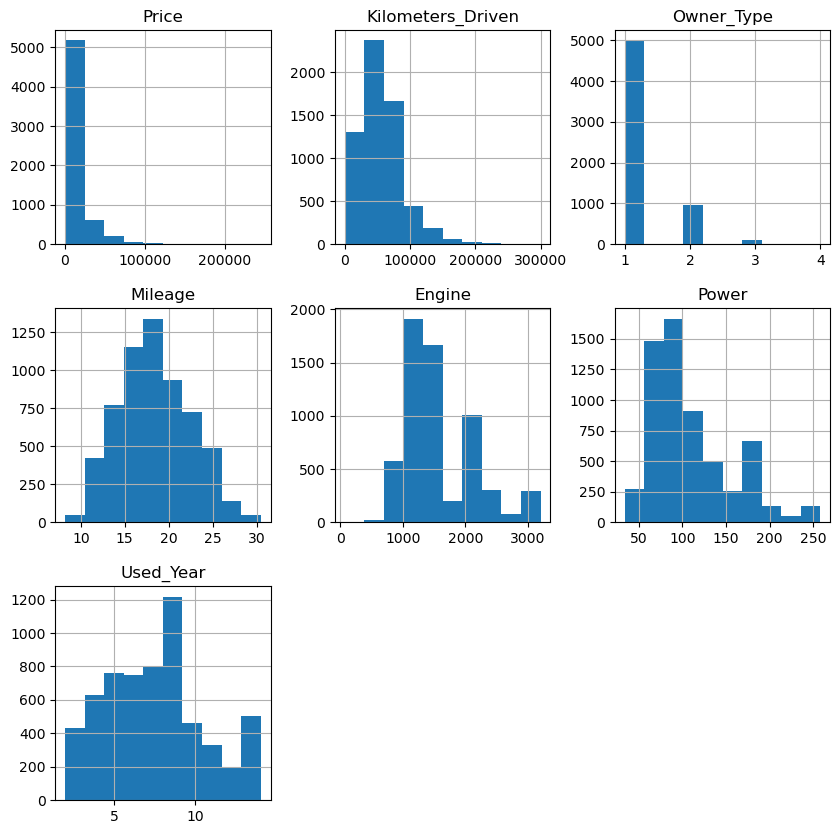

In [32]:
df.hist(figsize = (10,10))

### 가설검정

- 동,서,남,북으로 나누어진 지역별로 차이가 있을 것이다.
- H0 : mu1 == mu2
- H1 : mu1 != mu2


In [132]:
# 가설검정
"""
- 동, 서, 남, 북으로 나누어진 지역별로 가격 차이가 있을 것이다.
H0 : mu1 == mu2
H1 : mu1 != mu2
"""

'\n- 동, 서, 남, 북으로 나누어진 지역별로 가격 차이가 있을 것이다.\nH0 : mu1 == mu2\nH1 : mu1 != mu2\n'

In [ ]:
check = df[["Price", "Location_2"]]
W = check[ check["Location_2"] == "W"]["Price"].reset_index(drop = True)
S = check[ check["Location_2"] == "S"]["Price"].reset_index(drop = True)
N = check[ check["Location_2"] == "N"]["Price"].reset_index(drop = True)
E = check[ check["Location_2"] == "E"]["Price"].reset_index(drop = True)

min_length = min(len(W), len(S), len(N), len(E))

W = W[:min_length]
S = S[:min_length]
N = N[:min_length]
E = E[:min_length]

array1 = np.array(W)
array2 = np.array(S)
array3 = np.array(N)
array4 = np.array(E)

stat, p, dof, expected = chi2_contingency([array1, array2, array3, array4])

print("Chi-square Statistic:", stat)
print("p-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:", expected)

"""
P-value 값이 유의수준 0.05보다 낮게 나타났다. 따라서 귀무가설인 지역별로 차이가 없다를 기각할 근거가 있으므로 대립가설인 지역 간의 가격 차이가 있다를 채택한다.
"""

Chi-square Statistic: 18050975.631334573
p-value: 0.0
Degrees of Freedom: 1653
Expected Frequencies: [[ 5622.62964505 10254.19430018 25700.63086423 ...  8959.09388058
   7044.08201615 12887.82435666]
 [ 7478.88896358 13639.52197162 34185.45710132 ... 11916.8560935
   9369.62072461 17142.62070069]
 [ 4995.90613949  9111.21583561 22835.92333641 ...  7960.4731145
   6258.91705717 11451.28967987]
 [ 3731.92525188  6806.04789259 17058.35869804 ...  5946.44691142
   4675.39020208  8554.07526277]]


'\nP-value 값이 유의수준 0.05보다 낮게 나타났다. 따라서 귀무가설인 지역별로 차이가 없다를 기각할 근거가 있으므로 대립가설인 지역 간의 가격 차이가 없다를 채택한다.\n'

### 데이터 인코딩 및 분할
- 원핫인코딩

In [33]:
df_cat = df.select_dtypes('object')
df_num = df.select_dtypes(exclude = 'object')

In [34]:
from sklearn.preprocessing import OneHotEncoder

In [35]:
ohe_all_df = pd.DataFrame()
for col in df_cat.columns:
    ohe = OneHotEncoder(sparse = False)
    ohe_array = ohe.fit_transform(df_cat[col].values.reshape(-1,1))
    ohe_df = pd.DataFrame(ohe_array, columns = [f'{col}_{lev}' for lev in df_cat[col].unique()])
    
    ohe_all_df = pd.concat([ohe_all_df,ohe_df],axis =1 )
ohe_all_df.head()

,Fuel_Type_ETC,Fuel_Type_Diesel,Fuel_Type_Petrol,Transmission_Manual,Transmission_Automatic,Seats_5,Seats_7,Seats_8,Seats_4,Seats_6,Seats_2,Seats_10,Seats_9,Location_2_W,Location_2_S,Location_2_N,Location_2_E,BRAND_TIER_Low,BRAND_TIER_High,BRAND_TIER_Middle
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [36]:
df_encoded = pd.concat([df_num,ohe_all_df],axis = 1)
# df_encoded.drop(columns = df_cat.columns, inplace = True)
df_encoded.head()

,Price,Kilometers_Driven,Owner_Type,Mileage,Engine,Power,Used_Year,Fuel_Type_ETC,Fuel_Type_Diesel,Fuel_Type_Petrol,...,Seats_2,Seats_10,Seats_9,Location_2_W,Location_2_S,Location_2_N,Location_2_E,BRAND_TIER_Low,BRAND_TIER_High,BRAND_TIER_Middle
0,2682.68,72000,1,26.60,998,58.16,11,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,19162.00,41000,1,19.67,1582,126.20,6,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,6898.32,46000,1,18.20,1199,88.70,10,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,9197.76,87000,1,20.77,1248,88.76,9,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,27194.71,40670,2,15.20,1968,140.80,8,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [37]:
df_encoded_y = df_encoded['Price']
df_encoded_x = df_encoded.drop(columns = ['Price'])

In [38]:
# 분류모델 통합 평가 함수
def eval_class_model(y_test, y_pred):
#     confusion = confusion_matrix(y_test,y_pred)
#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test,y_pred)
#     recall = f1_score(y_test, y_pred)
#     f1 = f1_score(y_test,y_pred)
#     AUC = roc_auc_score(y_test,y_pred)
    r2 = r2_score(y_test,y_pred)
    mse = mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    mae = mean_absolute_error(y_test,y_pred)
    mape = mean_absolute_percentage_error(y_test,y_pred)
    print('R2스코어 : {:.4f}'.format(r2))
    print('MSE : {:.4f}'.format(mse))
    print('RMSE : {:.4f}'.format(rmse))
    print('MAE : {:.4f}'.format(mae))
    print('MAPE : {:.4f}'.format(mape))

In [39]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_encoded_x, df_encoded_y, test_size = 0.3)

print('>>>> train shape : {}'.format(df_train_x.shape))
print('>>>> test shaep : {}'.format(df_test_x.shape))

>>>> train shape : (4251, 26)
>>>> test shaep : (1823, 26)


# 모델링

# 1. XGBOOST

In [40]:
xgb_uncust = XGBRegressor()
xgb_uncust.fit(df_train_x,df_train_y)

print('\n>>>> train <<<<\n')
xgb_train_pred = xgb_uncust.predict(df_train_x)
eval_class_model(df_train_y, xgb_train_pred)

print('\n>>>> test <<<<\n')
xgb_test_pred = xgb_uncust.predict(df_test_x)
eval_class_model(df_test_y,xgb_test_pred)


>>>> train <<<<

R2스코어 : 0.9933
MSE : 1725715.7572
RMSE : 1313.6650
MAE : 839.3168
MAPE : 0.3705

>>>> test <<<<

R2스코어 : 0.8803
MSE : 27318306.6419
RMSE : 5226.6917
MAE : 2309.2389
MAPE : 0.1673


### n_estimators 트리 수 튜닝

,n_estimators,Train score,Test score
0,10,0.944,0.879
1,20,0.964,0.882
2,30,0.973,0.884
3,40,0.978,0.883
4,50,0.983,0.881
5,60,0.986,0.882
6,70,0.988,0.881
7,80,0.990,0.880
8,90,0.992,0.880
9,100,0.993,0.880


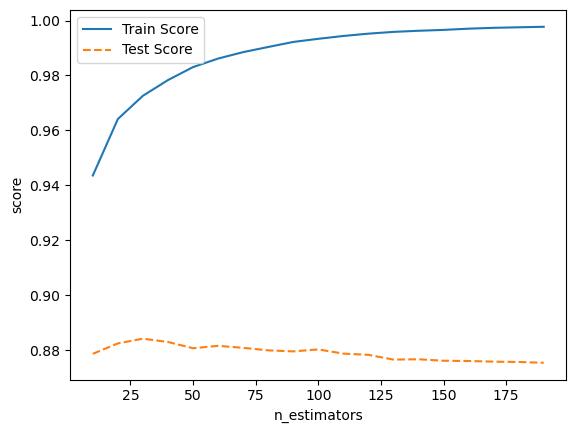

In [41]:
train_score = []
test_score = []

n_est = [n_tree * 10 for n_tree in range(1,20)]

for n in n_est:
    xgb_model = XGBRegressor(n_estimators = n)
    xgb_model.fit(df_train_x, df_train_y)
    train_score.append(xgb_model.score(df_train_x,df_train_y))
    test_score.append(xgb_model.score(df_test_x,df_test_y))

df_score_trees = pd.DataFrame()    
df_score_trees['n_estimators'] = n_est
df_score_trees['Train score'] = train_score
df_score_trees['Test score'] = test_score

display(df_score_trees.round(3))

plt.plot(n_est, train_score, linestyle = '-', label = 'Train Score')
plt.plot(n_est, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score')
plt.xlabel('n_estimators')
plt.legend()

#### 구간을 세분화

,n_estimators,Train score,Test score
0,1,0.431,0.448
1,2,0.654,0.657
2,3,0.774,0.766
3,4,0.842,0.815
4,5,0.882,0.846
5,6,0.905,0.863
6,7,0.920,0.869
7,8,0.931,0.872
8,9,0.938,0.875
9,10,0.944,0.879


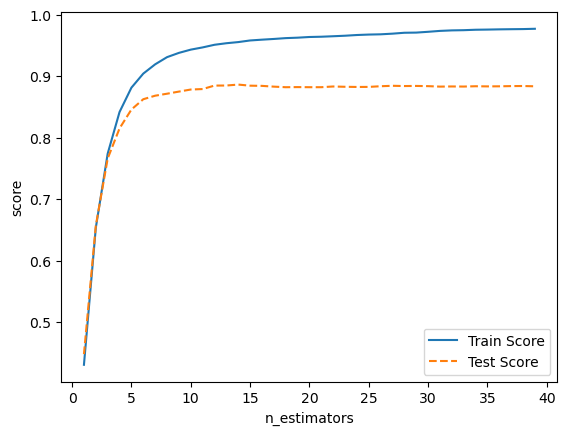

In [42]:
train_score = []
test_score = []

n_est = [n_tree for n_tree in range(1,40)]

for n in n_est:
    xgb_model = XGBRegressor(n_estimators = n)
    xgb_model.fit(df_train_x, df_train_y)
    train_score.append(xgb_model.score(df_train_x,df_train_y))
    test_score.append(xgb_model.score(df_test_x,df_test_y))

df_score_trees = pd.DataFrame()    
df_score_trees['n_estimators'] = n_est
df_score_trees['Train score'] = train_score
df_score_trees['Test score'] = test_score

display(df_score_trees.round(3))

plt.plot(n_est, train_score, linestyle = '-', label = 'Train Score')
plt.plot(n_est, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score')
plt.xlabel('n_estimators')
plt.legend()

### min_samples_split 튜닝

,m_split,Train score,Test score
0,2,0.938,0.875
1,4,0.938,0.875
2,6,0.938,0.875
3,8,0.938,0.875
4,10,0.938,0.875
5,12,0.938,0.875
6,14,0.938,0.875
7,16,0.938,0.875
8,18,0.938,0.875
9,20,0.938,0.875


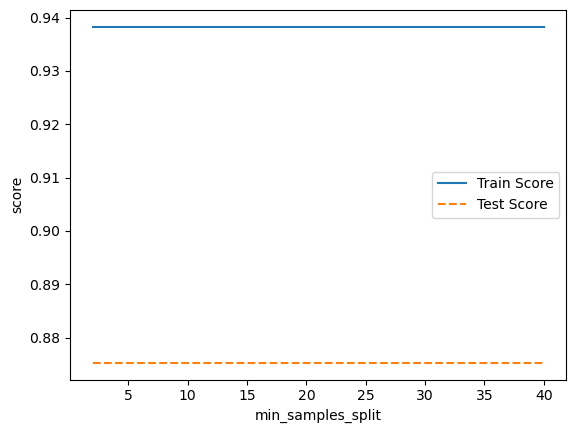

In [43]:
train_score = []
test_score = []

para_split = [n_split * 2 for n_split in range(1,21)]

for split_ in para_split:
    xgb_model = XGBRegressor(n_estimators = 9, min_samples_split = split_)
    xgb_model.fit(df_train_x, df_train_y)
    train_score.append(xgb_model.score(df_train_x,df_train_y))
    test_score.append(xgb_model.score(df_test_x,df_test_y))

df_score_split = pd.DataFrame()    
df_score_split['m_split'] = para_split
df_score_split['Train score'] = train_score
df_score_split['Test score'] = test_score

display(df_score_split.round(3))

plt.plot(para_split, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_split, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score')
plt.xlabel('min_samples_split')
plt.legend()

- min_samples_split은 모델 성능에 큰 영향을 주지 못하는 거 같으니 디폴트 결정

### max_depth 튜닝

,m_depth,Train score,Test score
0,1,0.672,0.710
1,2,0.815,0.845
2,3,0.861,0.873
3,4,0.894,0.879
4,5,0.920,0.891
5,6,0.938,0.875
6,7,0.956,0.876
7,8,0.967,0.871
8,9,0.975,0.866
9,10,0.980,0.875


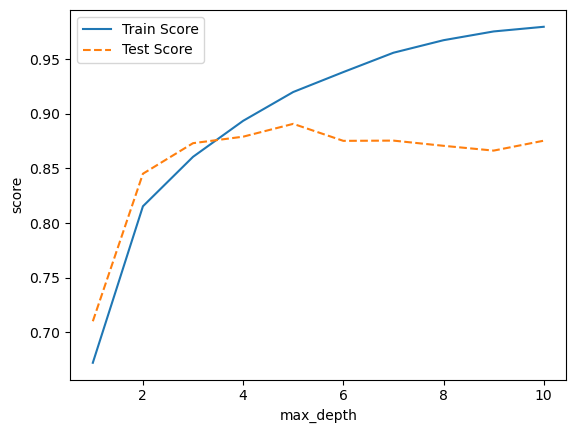

In [44]:
train_score = []
test_score = []

m_depth = [m for m in range(1,11)]

for m in m_depth:
    xgb_model = XGBRegressor(n_estimators = 9, max_depth = m)
    xgb_model.fit(df_train_x, df_train_y)
    train_score.append(xgb_model.score(df_train_x,df_train_y))
    test_score.append(xgb_model.score(df_test_x,df_test_y))

df_score_depth = pd.DataFrame()    
df_score_depth['m_depth'] = m_depth
df_score_depth['Train score'] = train_score
df_score_depth['Test score'] = test_score

display(df_score_depth.round(3))

plt.plot(m_depth, train_score, linestyle = '-', label = 'Train Score')
plt.plot(m_depth, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score')
plt.xlabel('max_depth')
plt.legend()

### 학습률 튜닝

,learning_rate,Train score,Test score
0,0.1,0.731,0.741
1,0.2,0.883,0.870
2,0.3,0.920,0.891
3,0.4,0.932,0.884
4,0.5,0.938,0.879
5,0.6,0.941,0.871
6,0.7,0.941,0.846
7,0.8,0.935,0.852
8,0.9,0.949,0.804


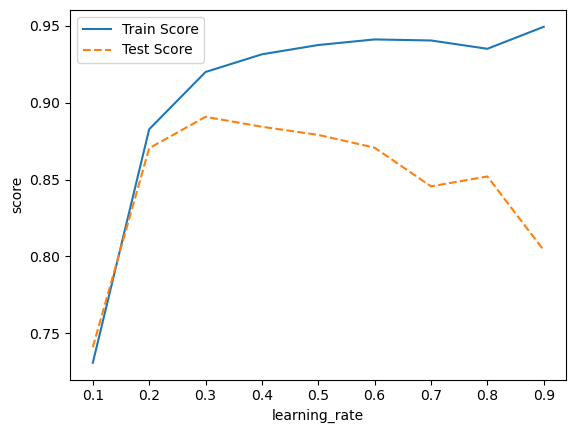

In [45]:

train_score = []
test_score = []

lrs = [l * 0.1 for l in range(1,10)]

for lr in lrs:
    xgb_model = XGBRegressor(n_estimators = 9, max_depth = 5,learning_rate = lr)
    xgb_model.fit(df_train_x, df_train_y)
    train_score.append(xgb_model.score(df_train_x,df_train_y))
    test_score.append(xgb_model.score(df_test_x,df_test_y))

df_score_lr = pd.DataFrame()    
df_score_lr['learning_rate'] = lrs
df_score_lr['Train score'] = train_score
df_score_lr['Test score'] = test_score

display(df_score_lr.round(3))

plt.plot(lrs, train_score, linestyle = '-', label = 'Train Score')
plt.plot(lrs, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score')
plt.xlabel('learning_rate')
plt.legend()

## 최종모델
- n_estimators = 9
- max_depth = 5
- learning_rate = 0.3

In [46]:
xgb_final = XGBRegressor(n_estimators = 9, max_depth = 5,learning_rate = 0.3)
xgb_final.fit(df_train_x, df_train_y)

print('Score on train : {:.3f}'.format(xgb_final.score(df_train_x,df_train_y)))
print('score on test : {:.3f}'.format(xgb_final.score(df_test_x,df_test_y)))

Score on train : 0.920
score on test : 0.891


In [47]:
models = ['XGBoost','RandomForest','LinearRegression']

mse, rmse, mae, mape = [],[],[],[]

xgb_pred = xgb_final.predict(df_test_x)

mse.append(mean_squared_error(df_test_y,xgb_pred))
rmse.append(mean_squared_error(df_test_y,xgb_pred,squared = False))
mae.append(mean_absolute_error(df_test_y, xgb_pred))
mape.append(mean_absolute_percentage_error(df_test_y,xgb_pred))

### 피처 중요도

Text(0, 0.5, 'feature')

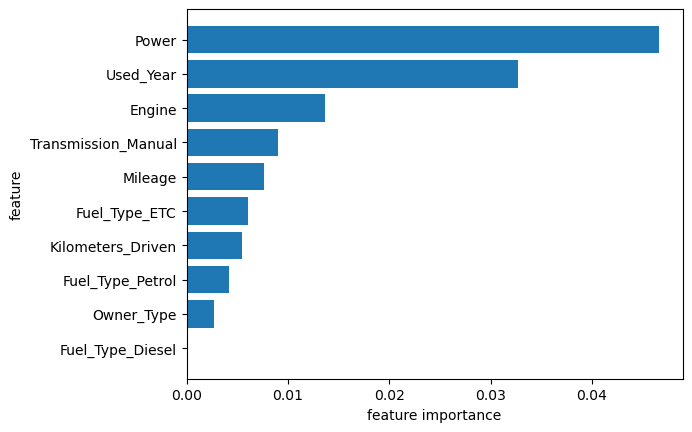

In [48]:
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = xgb_final.feature_importances_
df_importance = df_importance[:10]
df_importance.sort_values('Importance',ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('feature importance')
plt.ylabel('feature')

- 최대 출력, 사용연수, 엔진이 가격에 가장 큰 영향을 주는 변수이다.

In [49]:
# 분류모델 통합 평가 함수
def eval_class_model(y_test, y_pred):
#     confusion = confusion_matrix(y_test,y_pred)
#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test,y_pred)
#     recall = f1_score(y_test, y_pred)
#     f1 = f1_score(y_test,y_pred)
#     AUC = roc_auc_score(y_test,y_pred)
    r2 = r2_score(y_test,y_pred)
    mse = mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    mae = mean_absolute_error(y_test,y_pred)
    mape = mean_absolute_percentage_error(y_test,y_pred)
    print('R2스코어 : {:.4f}'.format(r2))
    print('MSE : {:.4f}'.format(mse))
    print('RMSE : {:.4f}'.format(rmse))
    print('MAE : {:.4f}'.format(mae))
    print('MAPE : {:.4f}'.format(mape))

In [50]:
y_train_pred = xgb_final.predict(df_train_x)
print('Train 성능\n',eval_class_model(df_train_y,y_train_pred))

R2스코어 : 0.9200
MSE : 20724396.0282
RMSE : 4552.4055
MAE : 2390.9100
MAPE : 0.5657
Train 성능
 None


In [51]:
y_test_pred = xgb_final.predict(df_test_x)
print('Test 성능\n',eval_class_model(df_test_y,y_test_pred))

R2스코어 : 0.8909
MSE : 24898824.1460
RMSE : 4989.8722
MAE : 2670.6956
MAPE : 0.2413
Test 성능
 None


## 2. RandomForest

In [53]:
# 임의의 모델
rfr = RandomForestRegressor(n_estimators=100, max_depth = 6, random_state=42)
rfr.fit(df_train_x, df_train_y)

RandomForestRegressor(max_depth=6, random_state=42)

In [54]:
train_score = []
test_score = [] 

# 학습 데이터로 모델 정확도 측정 
train_score.append(rfr.score(df_train_x, df_train_y))
print('train data Accuray', train_score)

test_score.append(rfr.score(df_test_x, df_test_y))
print('test data Accuray', test_score)

pred = rfr.predict(df_test_x)
# 테스트 데이터로 모델 정확도 측정 
rfr.score(df_test_x, df_test_y)
r2_score(df_test_y, pred)

# 실제값과 예측치 간 차이 가격 확인 가능  
mean_absolute_error(df_test_y, pred)

train data Accuray [0.9156733371455832]
test data Accuray [0.8857047931433926]


2784.0438771898957

### n_estimators 튜닝

In [55]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# n_estimatos: 트리 수 변경
para_n_tree = [n_tree * 10 for n_tree in range(1, 16)]

for v_n_estimators in para_n_tree:
    rf = RandomForestRegressor(n_estimators = v_n_estimators)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_n = pd.DataFrame()
df_accuracy_n["n_estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

,n_estimators,TrainAccuracy,TestAccuracy
0,10,0.977586,0.894199
1,20,0.979388,0.882206
2,30,0.979275,0.888047
3,40,0.982211,0.896488
4,50,0.979144,0.895618
5,60,0.980783,0.893280
6,70,0.980519,0.903902
7,80,0.981245,0.893186
8,90,0.979904,0.900136
9,100,0.981755,0.896526


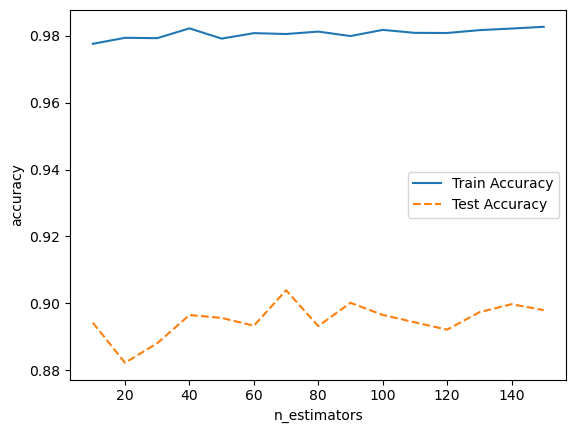

In [56]:
# 모델 정확도 그래프 확인
display(df_accuracy_n)
plt.plot(para_n_tree, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("n_estimators"); plt.ylabel("accuracy")
plt.legend()

- 구간세분화

In [57]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# n_estimatos: 트리 수 변경
para_n_tree = [n_tree for n_tree in range(1, 20)]

for v_n_estimators in para_n_tree:
    rf = RandomForestRegressor(n_estimators = v_n_estimators)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_n = pd.DataFrame()
df_accuracy_n["n_estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

,n_estimators,TrainAccuracy,TestAccuracy
0,1,0.897391,0.694716
1,2,0.946964,0.784262
2,3,0.953367,0.860012
3,4,0.966320,0.798205
4,5,0.968170,0.866214
5,6,0.965605,0.875160
6,7,0.973784,0.854176
7,8,0.972786,0.876123
8,9,0.972671,0.874855
9,10,0.975336,0.874212


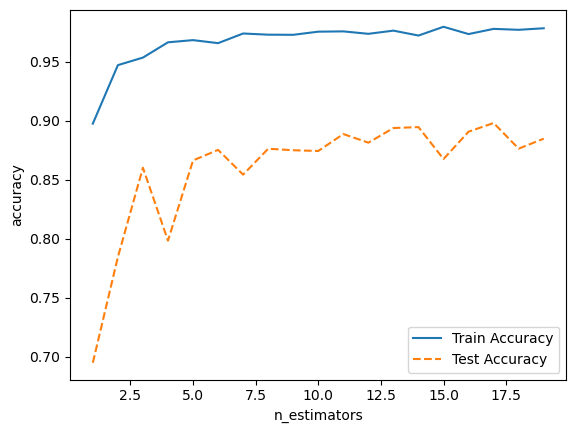

In [58]:
# 모델 정확도 그래프 확인
display(df_accuracy_n)
plt.plot(para_n_tree, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("n_estimators"); plt.ylabel("accuracy")
plt.legend()

#### min_samples_split 분리 노드 최소 자료수 튜닝

In [59]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_split: 분할하기 위한 노드의 최소 샘플 수.
para_split = [n_split * 2 for n_split in range(1, 22)]

for v_min_samples_split in para_split:
    rf = RandomForestRegressor(min_samples_split = v_min_samples_split,n_estimators=11)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,2,0.975758,0.870642
1,4,0.964745,0.878887
2,6,0.962157,0.882977
3,8,0.946161,0.887639
4,10,0.943166,0.885900
5,12,0.931798,0.882782
6,14,0.924711,0.885630
7,16,0.919016,0.900664
8,18,0.915093,0.896801
9,20,0.910191,0.896991


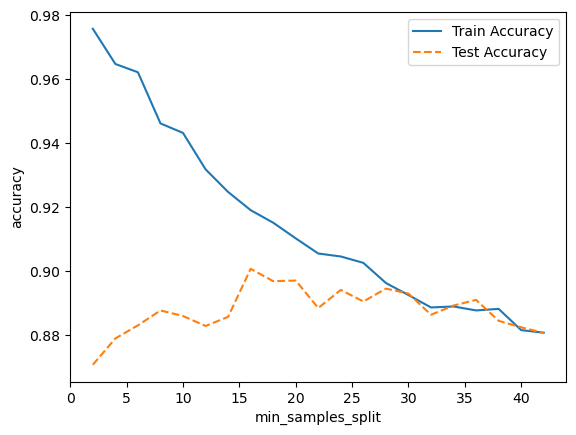

In [60]:
# 모델 정확도 그래프 확인
display(df_accuracy_split)
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min_samples_split"); plt.ylabel("accuracy")
plt.legend()

#### max_depth 튜닝

In [61]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_split: 분할하기 위한 노드의 최소 샘플 수.
para_depth = [depth for depth in range(1, 10)]

for v_max_depth in para_depth:
    rf = RandomForestRegressor(max_depth = v_max_depth, n_estimators=11)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy


,Depth,TrainAccuracy,TestAccuracy
0,1,0.533824,0.557269
1,2,0.683708,0.716942
2,3,0.798727,0.821886
3,4,0.846495,0.853244
4,5,0.880238,0.872614
5,6,0.912907,0.868537
6,7,0.932085,0.853749
7,8,0.938246,0.892080
8,9,0.957983,0.880578


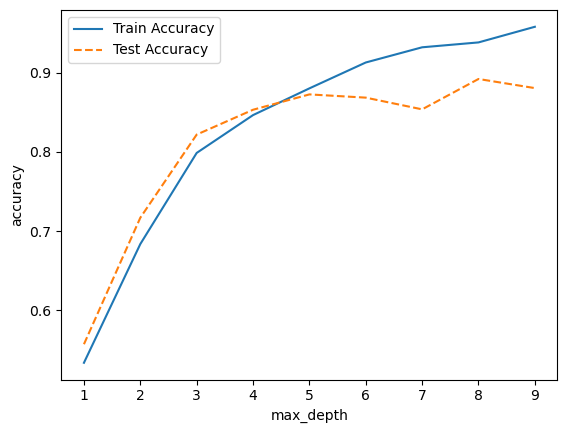

In [62]:
# 모델 정확도 그래프 확인
display(df_accuracy_depth)
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("max_depth"); plt.ylabel("accuracy")
plt.legend()

depth = 10 이후로 큰 차이를 보이지 않으니 깊이는 10으로 결정

### min_samples_leaf 튜닝

In [63]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_leaf: 잎사귀 수 제한
para_leaf = [n_leaf for n_leaf in range(1, 21)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestRegressor(min_samples_leaf = v_min_samples_leaf,
                                max_depth=5, n_estimators=11)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,1,0.881565,0.876685
1,2,0.878925,0.877050
2,3,0.875893,0.876140
3,4,0.874385,0.877819
4,5,0.871629,0.877206
5,6,0.870339,0.875602
6,7,0.869978,0.870942
7,8,0.865744,0.869221
8,9,0.864924,0.869392
9,10,0.864393,0.876209


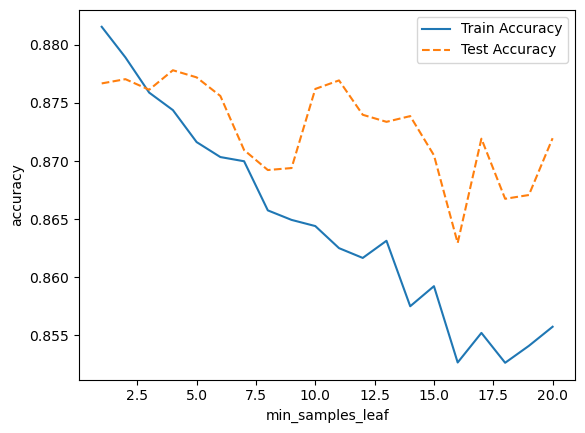

In [64]:
# 모델 정확도 그래프 확인
display(df_accuracy_leaf)
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min_samples_leaf"); plt.ylabel("accuracy")
plt.legend()

잎사귀 최소 자료수가 많아짐에 따라 과소적합 양상을 보이므로 특정값 지정하진 않겠다

## 랜덤포레스트 최종모델
- max_depth = 5
- n_estimators = 11

In [65]:
rfr = RandomForestRegressor(max_depth=5, n_estimators=11)
rfr.fit(df_train_x, df_train_y)

RandomForestRegressor(max_depth=5, n_estimators=11)

In [66]:
train_score = []
test_score = [] 

# 학습 데이터로 모델 정확도 측정 
train_score.append(rfr.score(df_train_x, df_train_y))
print('train data Accuray', train_score)

test_score.append(rfr.score(df_test_x, df_test_y))
print('test data Accuray', test_score)

pred = rfr.predict(df_test_x)
# 테스트 데이터로 모델 정확도 측정 
rfr.score(df_test_x, df_test_y) # y_test가 없음
r2_score(df_test_y, pred) # y_test가 없음

# 테스트 데이터 내 라벨 데이터(=y_test)가 없을 경우
# pred 결과를 리스트에 받아 데이터프레임으로 저장

# 실제값과 예측치 간 차이 가격 확인 가능  
mean_absolute_error(df_test_y, pred)

train data Accuray [0.8751223466853923]
test data Accuray [0.8726793598645733]


3089.299528400913

- train, test 성능 차이를 확인하니 정적합된 모델로 보인다.

In [67]:
# # 분류모델 통합 평가 함수
# def eval_class_model(y_test, y_pred):
# #     confusion = confusion_matrix(y_test,y_pred)
# #     accuracy = accuracy_score(y_test, y_pred)
# #     precision = precision_score(y_test,y_pred)
# #     recall = f1_score(y_test, y_pred)
# #     f1 = f1_score(y_test,y_pred)
# #     AUC = roc_auc_score(y_test,y_pred)
#     r2 = r2_score(y_test,y_pred)
#     mse = mean_squared_error(y_test,y_pred)
#     rmse = np.sqrt(mean_squared_error(y_test,y_pred))
#     mae = mean_absolute_error(y_test,y_pred)
#     mape = mean_absolute_percentage_error(y_test,y_pred)
#     print('R2스코어 : {:.4f}'.format(r2))
#     print('MSE : {:.4f}'.format(mse))
#     print('RMSE : {:.4f}'.format(rmse))
#     print('MAE : {:.4f}'.format(mae))
#     print('MAPE : {:.4f}'.format(mape))

y_train_pred = rfr.predict(df_train_x)
print('Train 성능\n',eval_class_model(df_train_y,y_train_pred))

y_test_pred = rfr.predict(df_test_x)
print('Test 성능\n',eval_class_model(df_test_y,y_test_pred))

R2스코어 : 0.8751
MSE : 32359603.0610
RMSE : 5688.5502
MAE : 2988.8274
MAPE : 0.5793
Train 성능
 None
R2스코어 : 0.8727
MSE : 29047778.5637
RMSE : 5389.5991
MAE : 3089.2995
MAPE : 0.2788
Test 성능
 None


### 피처 중요도

In [68]:
v_feature_name = df_train_x.columns
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = rfr.feature_importances_

df_importance.sort_values('Importance', ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
23,BRAND_TIER_Low,0.529
4,Power,0.214
5,Used_Year,0.200
3,Engine,0.031
0,Kilometers_Driven,0.010
2,Mileage,0.009
9,Transmission_Manual,0.002
15,Seats_6,0.002
24,BRAND_TIER_High,0.001
25,BRAND_TIER_Middle,0.001


Text(0, 0.5, 'feature')

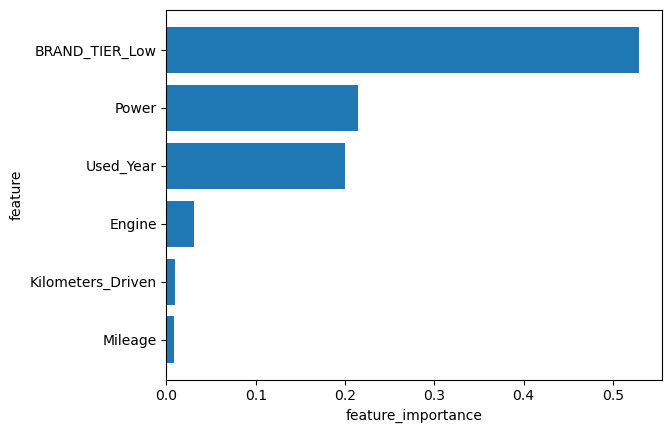

In [69]:
# 설명변수 중요도 그래프
df_importance = df_importance[df_importance["Importance"] > 0.005]
df_importance.sort_values('Importance', ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('feature_importance')
plt.ylabel('feature')

- 저가 브랜드 여부, 최대 출력, 사용연수가 가격에 영향을 많이 미치는 변수로 나왔다.

In [70]:
models = ['XGBoost','RandomForest','DecisionTree','LinearRegression']

mse, rmse, mae, mape = [],[],[],[]

xgb_pred = xgb_final.predict(df_test_x)

mse.append(mean_squared_error(df_test_y,xgb_pred))
rmse.append(mean_squared_error(df_test_y,xgb_pred,squared = False))
mae.append(mean_absolute_error(df_test_y, xgb_pred))
mape.append(mean_absolute_percentage_error(df_test_y,xgb_pred))

In [71]:
rfr_pred = rfr.predict(df_test_x)

mse.append(mean_squared_error(df_test_y,rfr_pred))
rmse.append(mean_squared_error(df_test_y,rfr_pred,squared = False))
mae.append(mean_absolute_error(df_test_y, rfr_pred))
mape.append(mean_absolute_percentage_error(df_test_y,rfr_pred))

# 3. 의사결정나무

In [72]:
from sklearn.tree import DecisionTreeRegressor

In [102]:
tree_uncust = DecisionTreeRegressor()
tree_uncust.fit(df_train_x,df_train_y)

print('Score on training set : {:.3f}'.format(tree_uncust.score(df_train_x,df_train_y)))
print('Score on test set : {:.3f}'.format(tree_uncust.score(df_test_x,df_test_y)))

Score on training set : 1.000
Score on test set : 0.728


### 잎사귀 노드 최소 자료수

In [103]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_leaf: 잎사귀 수 제한
para_leaf = [n_leaf for n_leaf in range(1, 41)]

for v_min_samples_leaf in para_leaf:
    dt = DecisionTreeRegressor(min_samples_leaf = v_min_samples_leaf)
    dt.fit(df_train_x, df_train_y)
    train_accuracy.append(dt.score(df_train_x, df_train_y))
    test_accuracy.append(dt.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,1,0.999996,0.726544
1,2,0.974761,0.768196
2,3,0.960738,0.780359
3,4,0.946739,0.788962
4,5,0.939493,0.795624
5,6,0.935267,0.791384
6,7,0.925777,0.793033
7,8,0.919428,0.790156
8,9,0.915053,0.791183
9,10,0.910377,0.795646


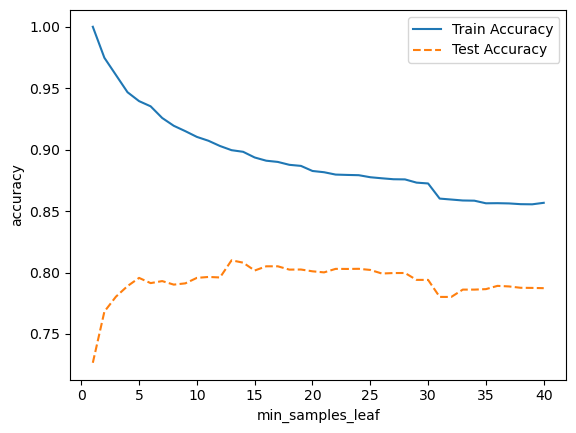

In [104]:
# 모델 정확도 그래프 확인
display(df_accuracy_leaf)
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min_samples_leaf"); plt.ylabel("accuracy")
plt.legend()

- min_samples_leaf => 13결정

### 분리 노드 최소 자료수 튜닝

In [105]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_leaf: 잎사귀 수 제한
para_split = [s*2 for s in range(2, 20)]

for split_ in para_split:
    dt = DecisionTreeRegressor(min_samples_leaf = 13, min_samples_split = split_)
    dt.fit(df_train_x, df_train_y)
    train_accuracy.append(dt.score(df_train_x, df_train_y))
    test_accuracy.append(dt.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesSplit"] = para_split
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,4,0.899567,0.809961
1,6,0.899567,0.809947
2,8,0.899567,0.809947
3,10,0.899567,0.809961
4,12,0.899567,0.809946
5,14,0.899567,0.809948
6,16,0.899567,0.809960
7,18,0.899567,0.809947
8,20,0.899567,0.809947
9,22,0.899567,0.809948


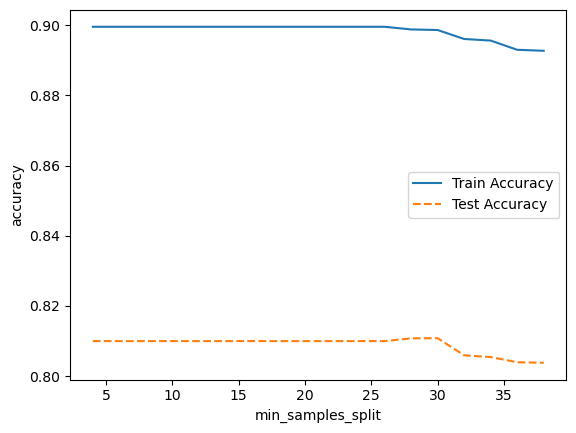

In [106]:
# 모델 정확도 그래프 확인
display(df_accuracy_leaf)
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min_samples_split"); plt.ylabel("accuracy")
plt.legend()

- 디폴트 결정

### 최대 깊이 조정

In [107]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_leaf: 잎사귀 수 제한
para_depth = [d for d in range(1, 8)]

for d in para_depth:
    dt = DecisionTreeRegressor(min_samples_leaf = 13,max_depth = d)
    dt.fit(df_train_x, df_train_y)
    train_accuracy.append(dt.score(df_train_x, df_train_y))
    test_accuracy.append(dt.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["MaxDepth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

,MaxDepth,TrainAccuracy,TestAccuracy
0,1,0.529508,0.427724
1,2,0.667197,0.582723
2,3,0.755006,0.694472
3,4,0.813257,0.750757
4,5,0.848305,0.787493
5,6,0.874322,0.803812
6,7,0.884671,0.806559


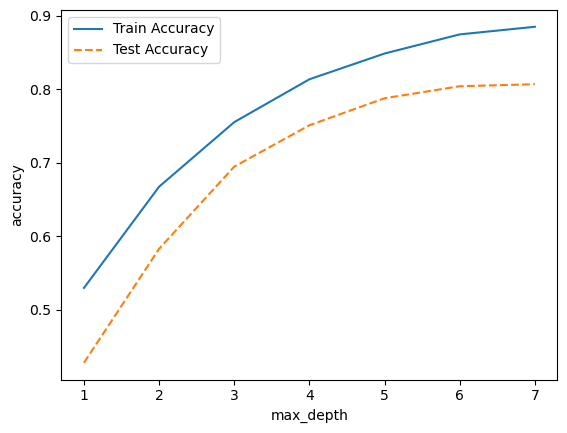

In [108]:
# 모델 정확도 그래프 확인
display(df_accuracy_depth)
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("max_depth"); plt.ylabel("accuracy")
plt.legend()

- depth 4로 결정

## 의사결정나무 최종모델
- min_samples_leaf = 13
- max_depth = 4

In [109]:
v_feature_name = df_train_x.columns
tree_final = DecisionTreeRegressor(min_samples_leaf = 13,max_depth = 4)
tree_final.fit(df_train_x,df_train_y)

train_score = []
test_score = [] 

# 학습 데이터로 모델 정확도 측정 
train_score.append(tree_final.score(df_train_x, df_train_y))
print('train data Accuray', train_score)

test_score.append(tree_final.score(df_test_x, df_test_y))
print('test data Accuray', test_score)

pred = tree_final.predict(df_test_x)
# 테스트 데이터로 모델 정확도 측정 
tree_final.score(df_test_x, df_test_y) # y_test가 없음
r2_score(df_test_y, pred) # y_test가 없음

# 테스트 데이터 내 라벨 데이터(=y_test)가 없을 경우
# pred 결과를 리스트에 받아 데이터프레임으로 저장

# 실제값과 예측치 간 차이 가격 확인 가능  
mean_absolute_error(df_test_y, pred)

train data Accuray [0.8132565162393492]
test data Accuray [0.7507566797210838]


4420.1813912942425

In [110]:
y_train_pred = tree_final.predict(df_train_x)
print('Train 성능\n',eval_class_model(df_train_y,y_train_pred))

y_test_pred = tree_final.predict(df_test_x)
print('Test 성능\n',eval_class_model(df_test_y,y_test_pred))

R2스코어 : 0.8133
MSE : 44110752.5156
RMSE : 6641.5926
MAE : 3915.0081
MAPE : 0.6279
Train 성능
 None
R2스코어 : 0.7508
MSE : 70154923.2102
RMSE : 8375.8536
MAE : 4420.1814
MAPE : 0.4089
Test 성능
 None


### 트리 시각화

In [82]:
df["BRAND_TIER"]

0          Low
1          Low
2          Low
3          Low
4         High
         ...  
6069       Low
6070    Middle
6071      High
6072       Low
6073       Low
Name: BRAND_TIER, Length: 6074, dtype: object

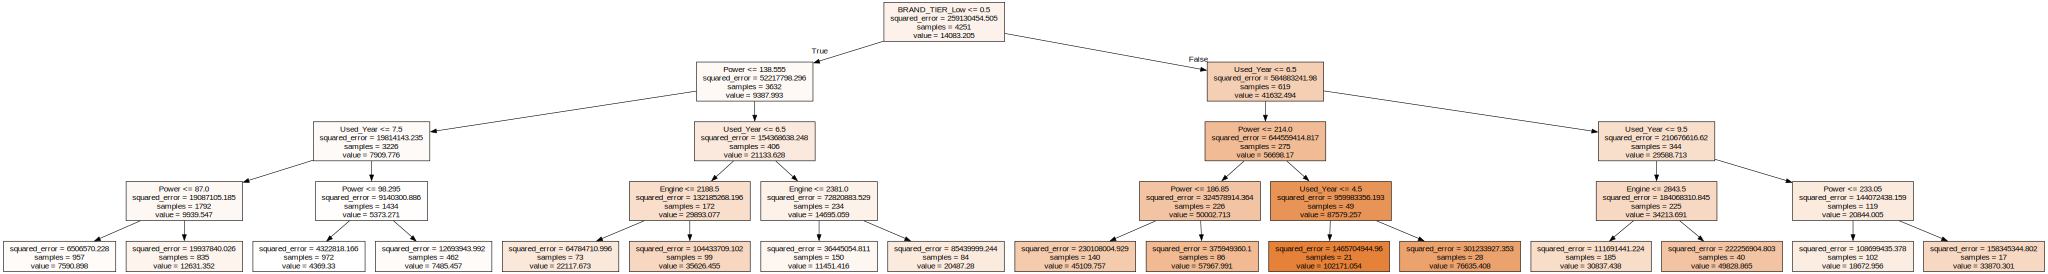

In [83]:
export_graphviz(tree_final, out_file = 'car_tree_final2.dot',
               feature_names = v_feature_name, impurity = True, filled = True)
with open('car_tree_final2.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# plt.savefig(fname = 'dtdt',dpi = 300, bbox_inches = 'tight')

#### 피처 중요도

In [84]:
v_feature_name = df_train_x.columns
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = tree_final.feature_importances_

df_importance.sort_values('Importance', ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
23,BRAND_TIER_Low,0.615
5,Used_Year,0.194
4,Power,0.164
3,Engine,0.027
0,Kilometers_Driven,0.000
15,Seats_6,0.000
24,BRAND_TIER_High,0.000
22,Location_2_E,0.000
21,Location_2_N,0.000
20,Location_2_S,0.000


Text(0, 0.5, 'feature')

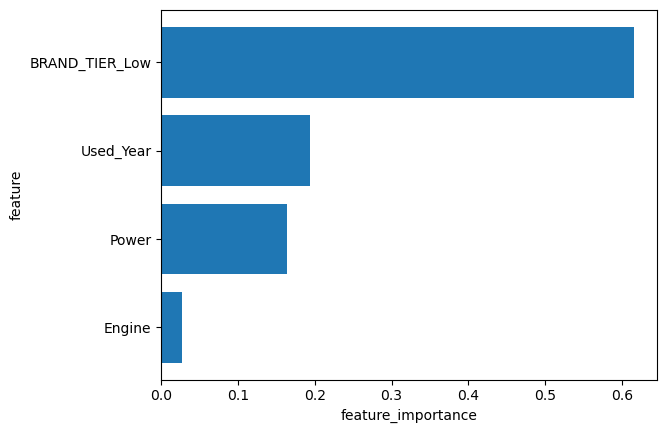

In [85]:
# 설명변수 중요도 그래프
df_importance = df_importance[df_importance["Importance"] > 0.005]
df_importance.sort_values('Importance', ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('feature_importance')
plt.ylabel('feature')

In [86]:
dt_pred = tree_final.predict(df_test_x)

mse.append(mean_squared_error(df_test_y,dt_pred))
rmse.append(mean_squared_error(df_test_y,dt_pred,squared = False))
mae.append(mean_absolute_error(df_test_y, dt_pred))
mape.append(mean_absolute_percentage_error(df_test_y,dt_pred))

In [87]:
train_score = []
test_score = [] 

# 학습 데이터로 모델 정확도 측정 
train_score.append(dt.score(df_train_x, df_train_y))
print('train data Accuray', train_score)

test_score.append(dt.score(df_test_x, df_test_y))
print('test data Accuray', test_score)

pred = dt.predict(df_test_x)
# 테스트 데이터로 모델 정확도 측정 
dt.score(df_test_x, df_test_y) # y_test가 없음
r2_score(df_test_y, pred) # y_test가 없음

# 테스트 데이터 내 라벨 데이터(=y_test)가 없을 경우
# pred 결과를 리스트에 받아 데이터프레임으로 저장

# 실제값과 예측치 간 차이 가격 확인 가능  
mean_absolute_error(df_test_y, pred)

train data Accuray [0.8713446933483753]
test data Accuray [0.8575494446671025]


2975.835029181144

# 4. 다중선형회귀
- 데이터 재구성
    - 원핫인코딩과 스케일링(standardscaler) 진행

In [90]:
from sklearn.preprocessing import StandardScaler

### 스케일링

In [91]:
df_y = df2['Price']
df_x = df2.drop("Price", axis = 1)

df_num = df_x.select_dtypes(exclude = "object")

v_feature_names = df_num.columns
scaler = StandardScaler()
df_x_scaled = scaler.fit_transform(df_num)
df_x_scaled = pd.DataFrame(df_x_scaled, columns=v_feature_names)

df_num_scaled = pd.concat([ df_y, df_x_scaled ], axis = 1)

### 원핫인코딩

In [92]:
#%% one - hot encoding
df_chr = df2.select_dtypes(include = "object")

ohe_df_all = pd.DataFrame()

for col in df_chr.columns:
    ohe = OneHotEncoder(sparse = False)
    ohe_data = ohe.fit_transform(df_chr[col].values.reshape(-1,1))
    ohe_df = pd.DataFrame(ohe_data, columns = df_chr[col].unique())
    ohe_df_all = pd.concat([ohe_df_all,ohe_df],axis=1)
    
df_encoded = pd.concat([df_y,ohe_df_all],axis = 1)


### 다중공선성 확인 및 VIF 10이상인 변수 제거

In [93]:
df_edit = pd.concat([ df_num_scaled, df_encoded.drop("Price", axis = 1) ], axis = 1)

#%% 데이터 분리
df_train, df_test, df_train_y, df_test_y = train_test_split( df_edit, df_edit["Price"], test_size = 0.3, random_state = 123)
print("train data size : {}".format(df_train_x.shape))
print("test data size : {}".format(df_test_x.shape))

#%% 회귀모델 생성
# - 다중공선성 확인
df_train_x = df_train.drop("Price", axis = 1)
df_train_x_const = add_constant(df_train_x)

df_test_x = df_test.drop("Price", axis = 1)



train data size : (4251, 26)
test data size : (1823, 26)


In [94]:
df_vif = pd.DataFrame()
df_vif["variable"] = df_train_x_const.columns
df_vif['VIF'] = [variance_inflation_factor(df_train_x_const.values, i) for i in range(df_train_x_const.shape[1])]
df_vif = df_vif[ df_vif["VIF"] <= 10 ][1:]["variable"].to_list()
df_vif

['Kilometers_Driven', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Used_Year']

In [95]:
import statsmodels.formula.api as smf

### 모델링

In [96]:
#%% - 모델 적합
fx = "Price ~ + " + "+".join(df_vif)
# fx = "Price ~ + Year+Kilometers_Driven+Power"
reg_model = smf.ols(formula = fx, data = df_train)
reg_result = reg_model.fit()
print(reg_result.summary())


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     1498.
Date:                Sun, 10 Mar 2024   Prob (F-statistic):               0.00
Time:                        04:44:19   Log-Likelihood:                -44595.
No. Observations:                4251   AIC:                         8.920e+04
Df Residuals:                    4244   BIC:                         8.925e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.405e+04    133.62

In [97]:
#%% - 모델 적합
fx = "Price ~ + " + "+".join(df_vif)
print(fx)
fx = "Price ~ + Kilometers_Driven+Mileage+Engine+Power+Used_Year"
reg_model = smf.ols(formula = fx, data = df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

Price ~ + Kilometers_Driven+Owner_Type+Mileage+Engine+Power+Used_Year
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     1798.
Date:                Sun, 10 Mar 2024   Prob (F-statistic):               0.00
Time:                        04:44:19   Log-Likelihood:                -44595.
No. Observations:                4251   AIC:                         8.920e+04
Df Residuals:                    4245   BIC:                         8.924e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

### 최종모델

In [98]:
#%% - 최종 모델 test 적합
reg_model = smf.ols(formula = fx, data = df_test)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     597.9
Date:                Sun, 10 Mar 2024   Prob (F-statistic):               0.00
Time:                        04:44:19   Log-Likelihood:                -19434.
No. Observations:                1823   AIC:                         3.888e+04
Df Residuals:                    1817   BIC:                         3.891e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.413e+04    242.08

- 최종 회귀식
- Price = 1.413e+04 -1207.5292 * Kilometers_Driven + 87.4446 * Mileage + 1579.0223 * Engine + 1.061e * Power -4828.4120 * Used_Year

In [100]:
lr_pred = reg_result.predict(df_test_x)

mse.append(mean_squared_error(df_test_y,lr_pred))
rmse.append(mean_squared_error(df_test_y,lr_pred,squared = False))
mae.append(mean_absolute_error(df_test_y, lr_pred))
mape.append(mean_absolute_percentage_error(df_test_y,lr_pred))

# 모델별 성능 비교

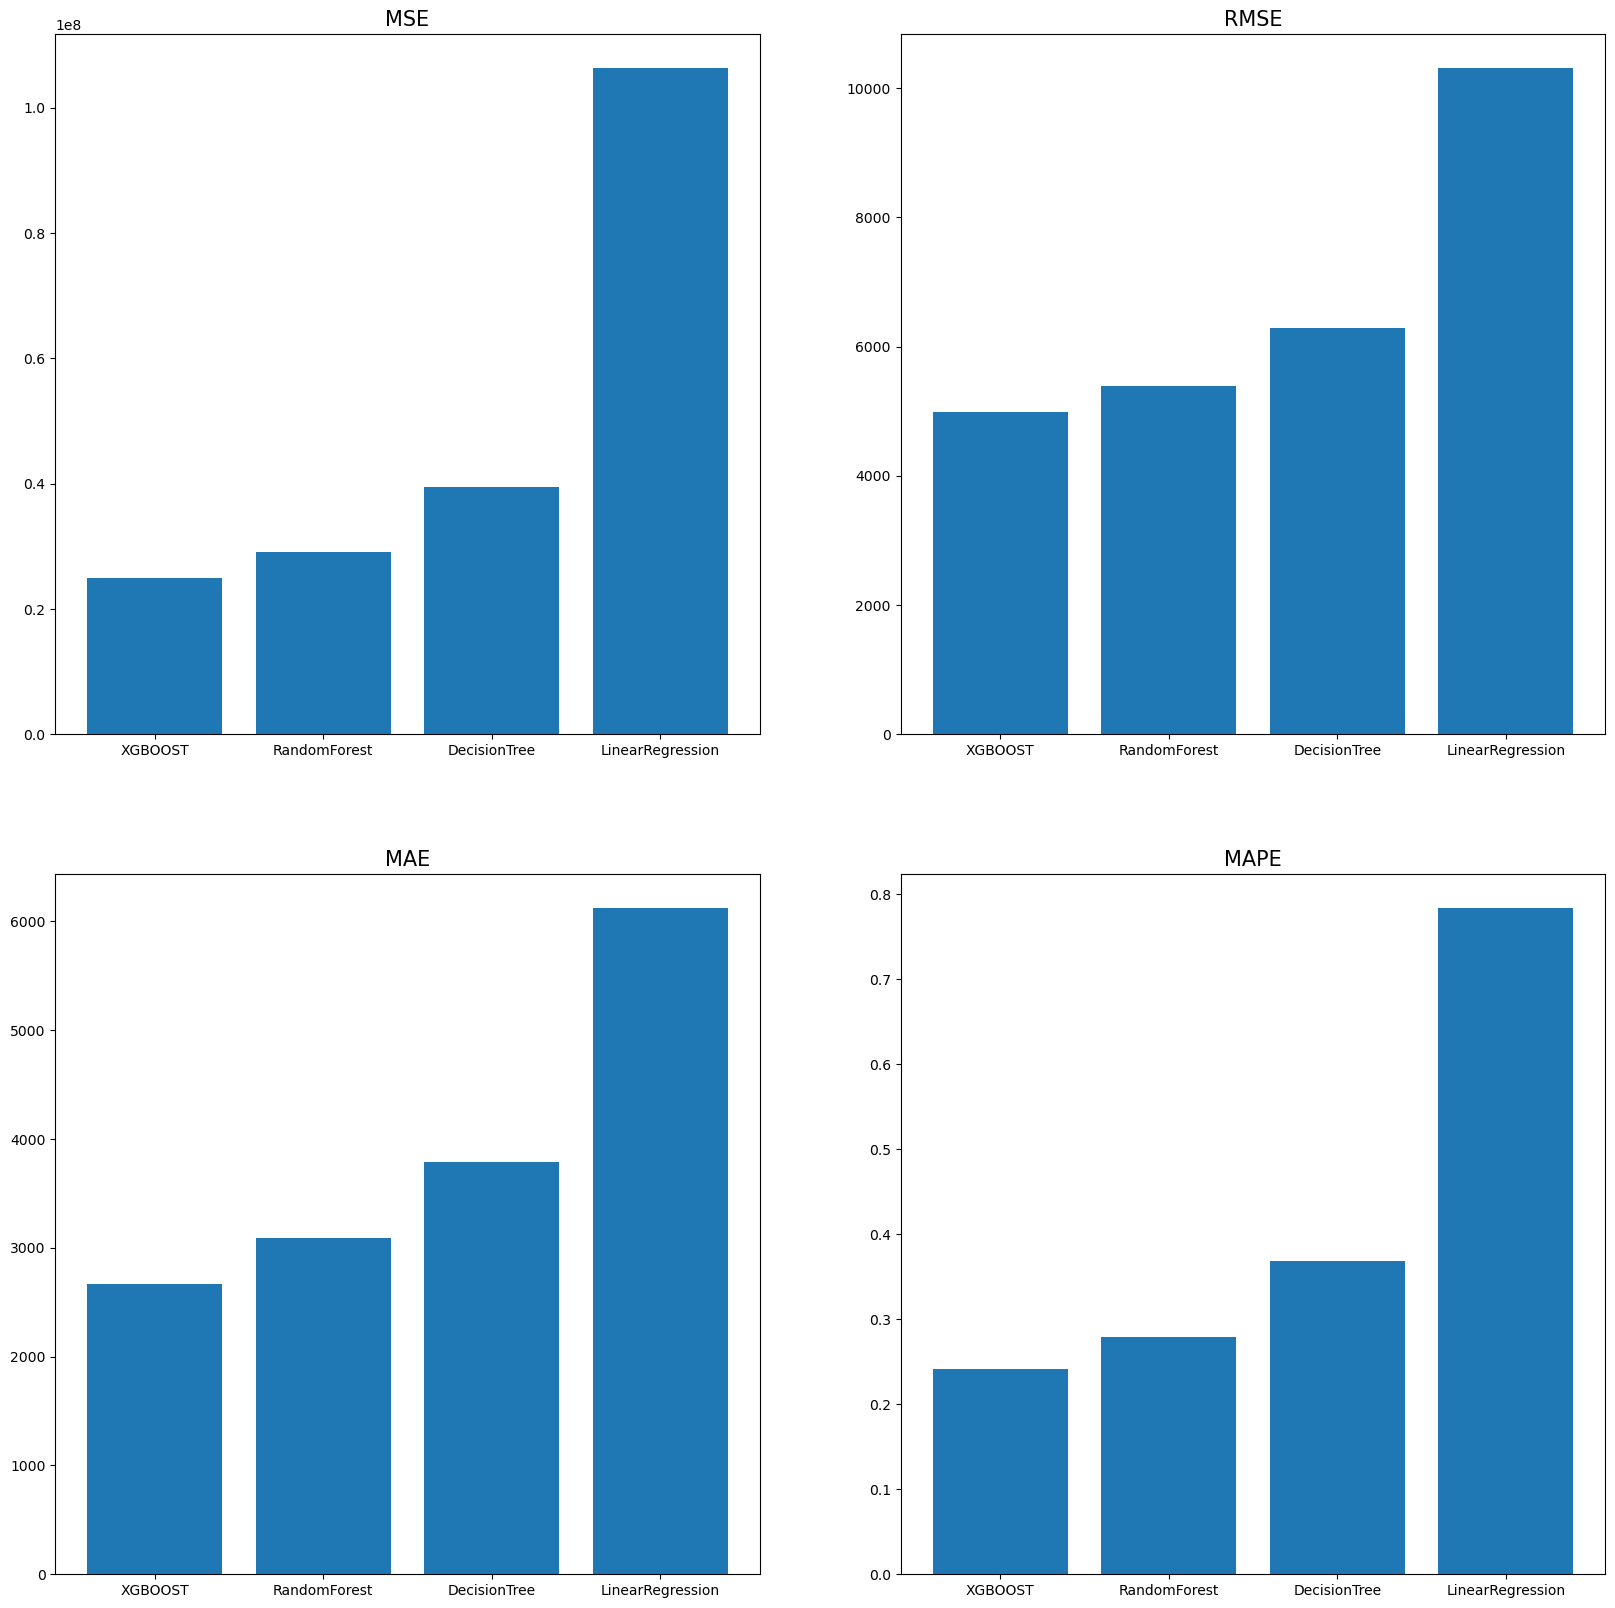

In [101]:
models = ['XGBOOST','RandomForest','DecisionTree','LinearRegression']

fig,ax = plt.subplots(nrows = 2, ncols =2 , figsize = (20,20))
ax[0,0].bar(models, mse)
ax[0,0].set_title('MSE').set_fontsize(15)

ax[0,1].bar(models,rmse)
ax[0,1].set_title('RMSE').set_fontsize(15)

ax[1,0].bar(models,mae)
ax[1,0].set_title('MAE').set_fontsize(15)

ax[1,1].bar(models,mape)
ax[1,1].set_title('MAPE').set_fontsize(15)